In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams["axes.prop_cycle"]
colours = prop_cycle.by_key()["color"]
colours

['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [2]:
intervention_labels = {"none": "None", "both": "Both", "pr": "PR", "sn": "SN"}

codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes",
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

In [3]:
knee_results = pd.read_csv(
    "../data/clusters/knee_results.csv", header=None
).set_index(0)
with open("../data/clusters/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

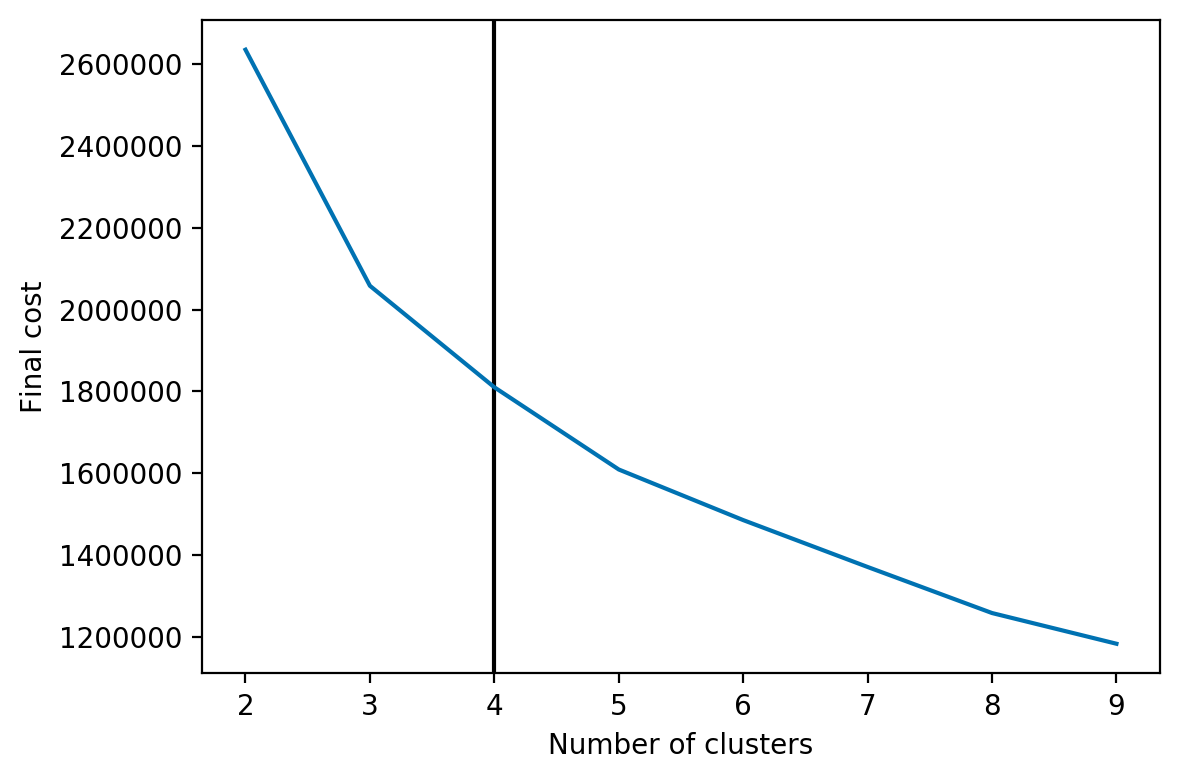

In [4]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)

ax.set(
    xlabel="Number of clusters",
    ylabel="Final cost",
    ylim=ylims,
)

plt.tight_layout()
plt.savefig("../img/knee_results.pdf", transparent=True)

In [5]:
copd = (
    pd.read_csv(
        "../data/clusters/copd_clustered.csv",
        parse_dates=["admission_date", "discharge_date"],
    )
    .dropna(subset=["cluster"])
    .drop_duplicates("spell_id")
)

copd["cluster"] = copd["cluster"].astype(int)

In [6]:
copd["cluster"].value_counts().sort_index(), len(copd)

(0    1075
 1    2093
 2    7535
 3     156
 Name: cluster, dtype: int64,
 10859)

In [7]:
los_xlims, los_ylims = (-10, 149), (-0.01, 0.199)

In [8]:
def histograms(
    data, column, group="cluster", density=True, colours=colours, bins=11
):

    fig, axes = plt.subplots(
        ncols=2, nrows=2, dpi=200, sharex=True, sharey=True
    )
    axes = axes.reshape(4)

    column_labels = {
        "wimd": "Welsh Index of Multiple Deprivation",
        "charlson_gross": "Charlson Comorbidity Index",
        "n_copd_admissions_last_year": "COPD admissions in last year",
        "n_icds": "No. of ICDs",
        "age": "Age (years)",
        "spell_cost": "Cost of spell (£1000s)",
        "n_episodes": "No. of episodes",
        "true_los": "Length of stay (days)",
    }

    str_ints = (x for x in range(10))
    for (label, values), ax in zip(copd.groupby(group)[column], axes):

        factor = 1000 if column == "spell_cost" else 1
        ax.hist(
            copd[column] / factor,
            bins=30,
            histtype="step",
            facecolor="tab:gray",
            edgecolor="k",
            fill=True,
            alpha=0.3,
            density=True,
            label="Overall",
        )

        label_name = intervention_labels.get(label, f"Cluster {label}")
        if isinstance(label, str):
            label = next(str_ints)
            colour = "tab:red"
        else:
            colour = colours[label]

        ax.hist(
            values / factor,
            bins=bins,
            histtype="step",
            fill=True,
            alpha=0.75,
            facecolor=colour,
            edgecolor=colour,
            density=True,
            label=label_name,
        )

        if column == "true_los":
            ax.set_xlim(los_xlims)

        if label > 1:
            ax.set_xlabel(column_labels[column])
        if label % 2 == 0:
            ax.set_ylabel("Frequency density")

        ax.legend()

    plt.tight_layout()
    plt.savefig(f"../img/{group}_{column}.pdf", transparent=True)

/Users/henrywilde/opt/anaconda3/envs/copd-paper/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/opt/anaconda3/envs/copd-paper/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/opt/anaconda3/envs/copd-paper/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/opt/anaconda3/envs/copd-paper/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


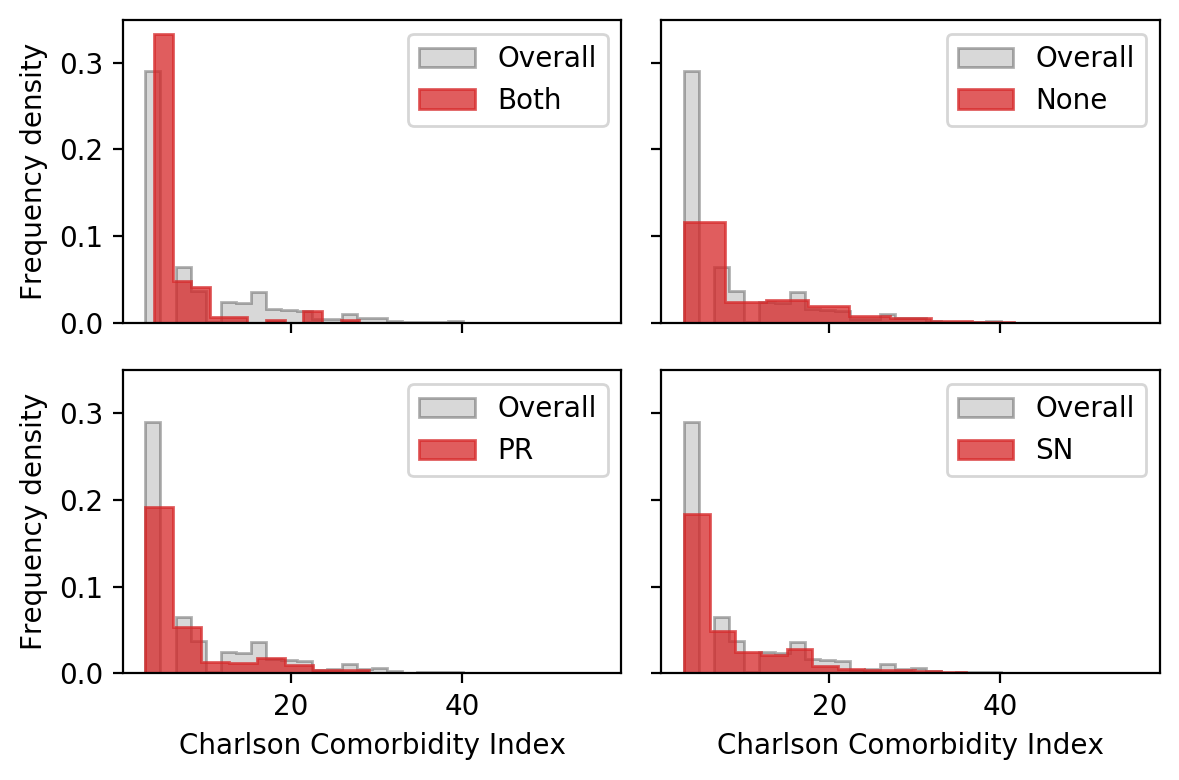

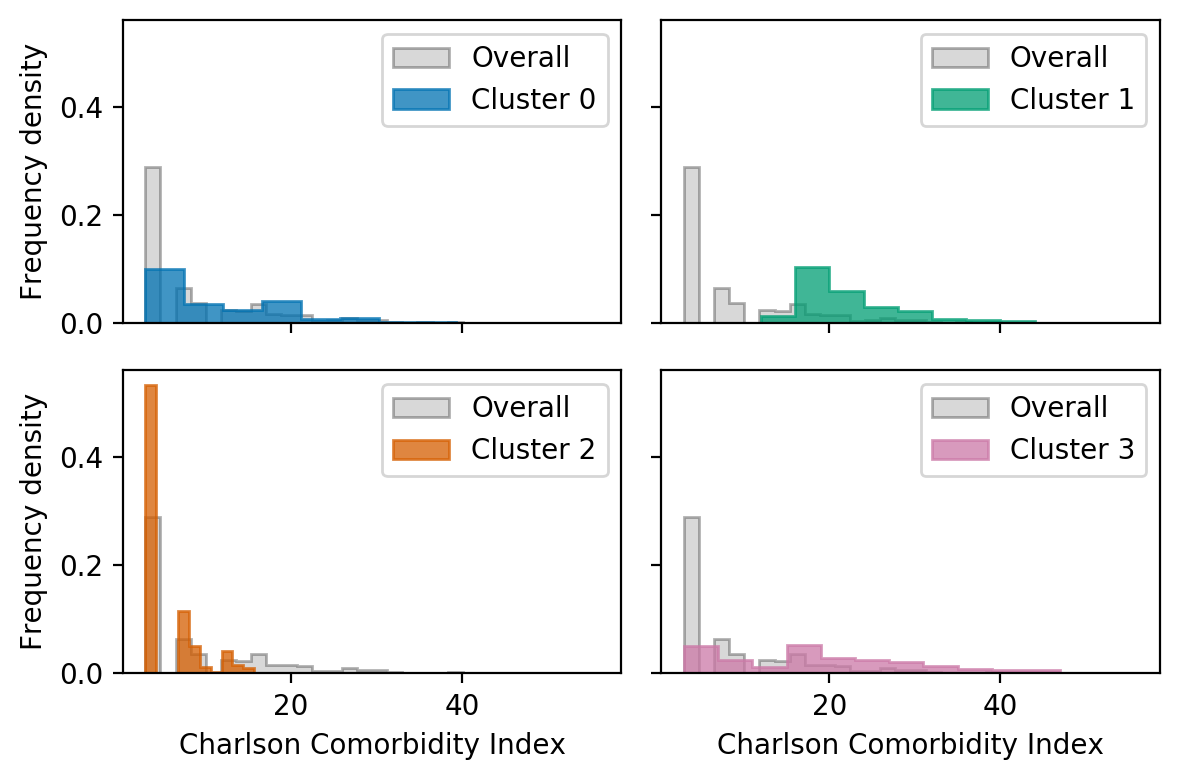

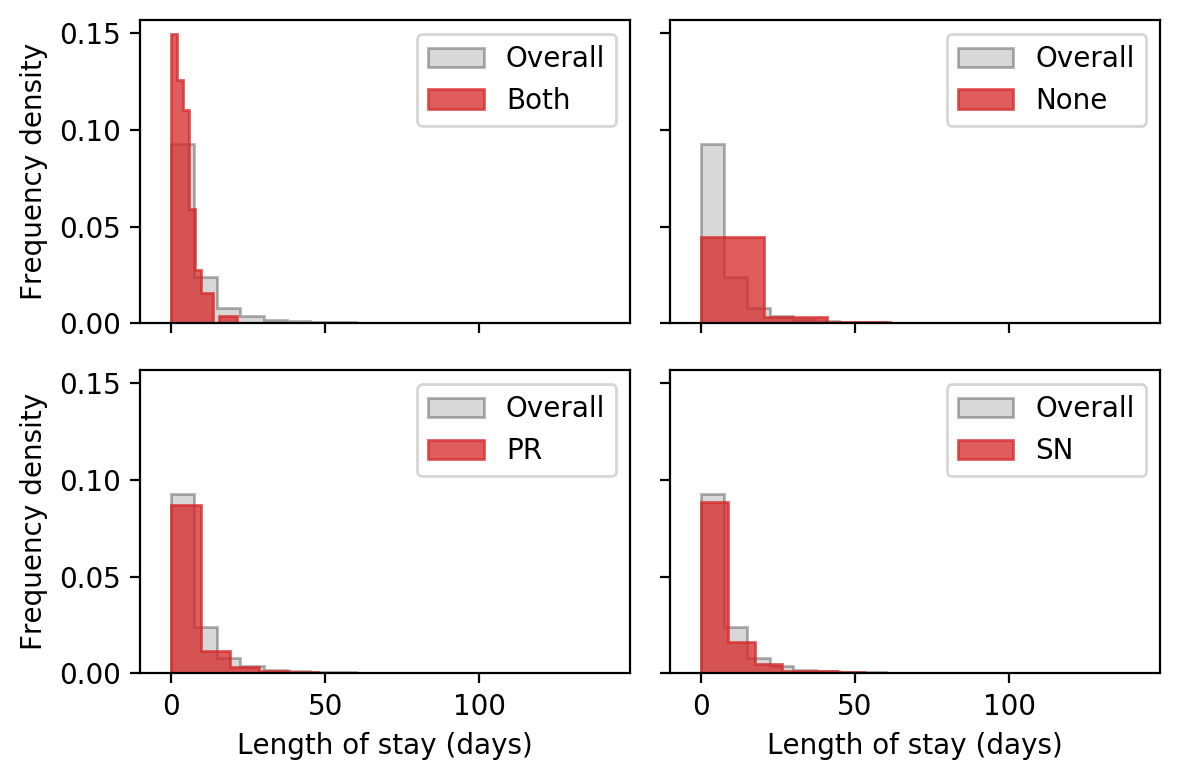

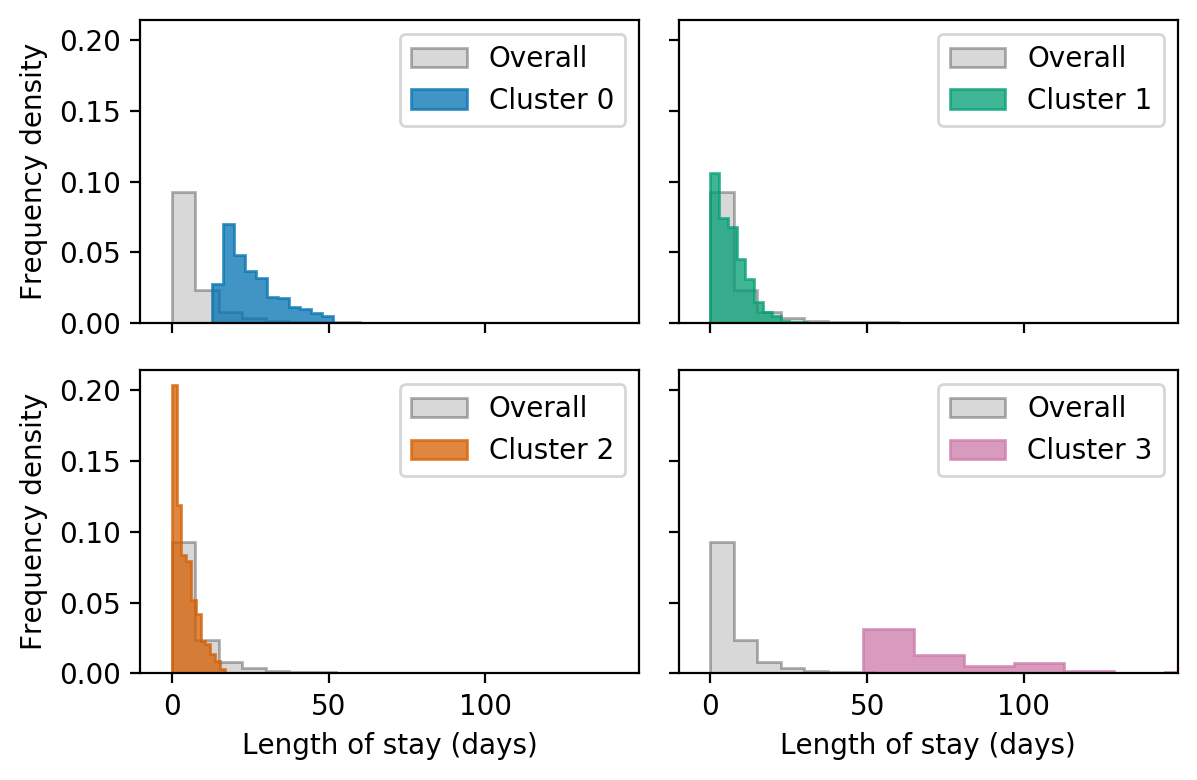

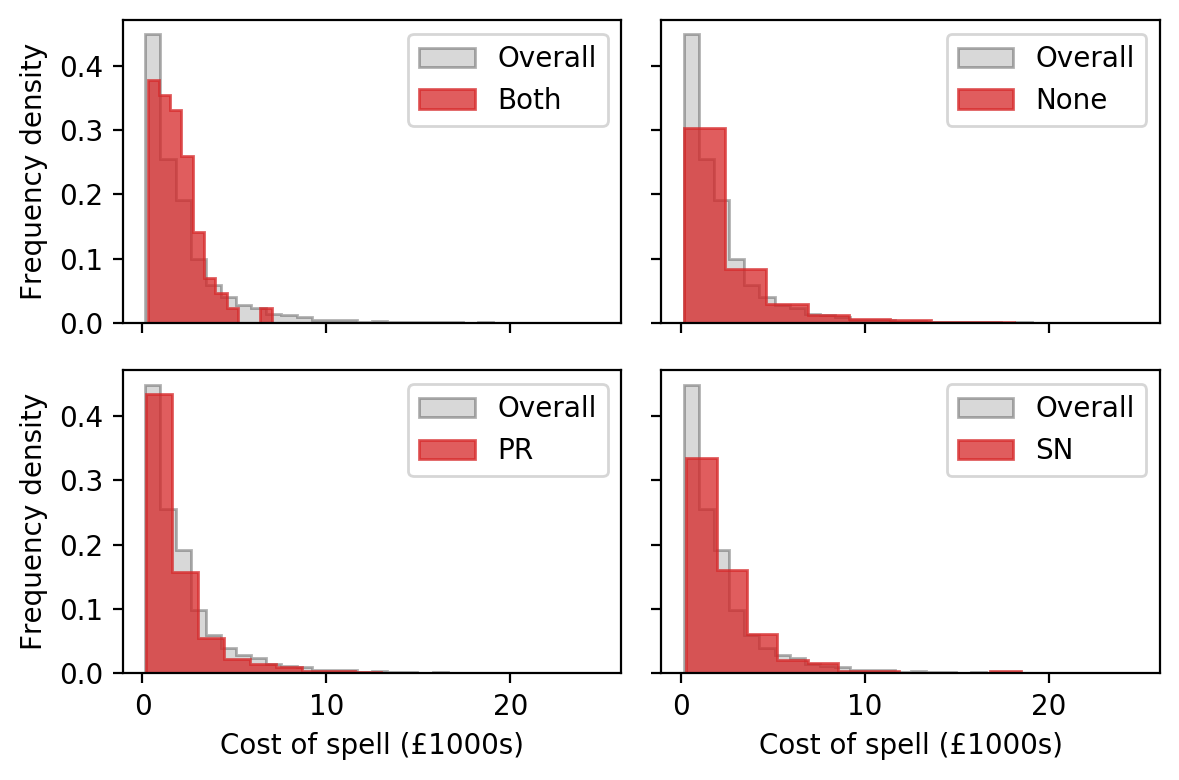

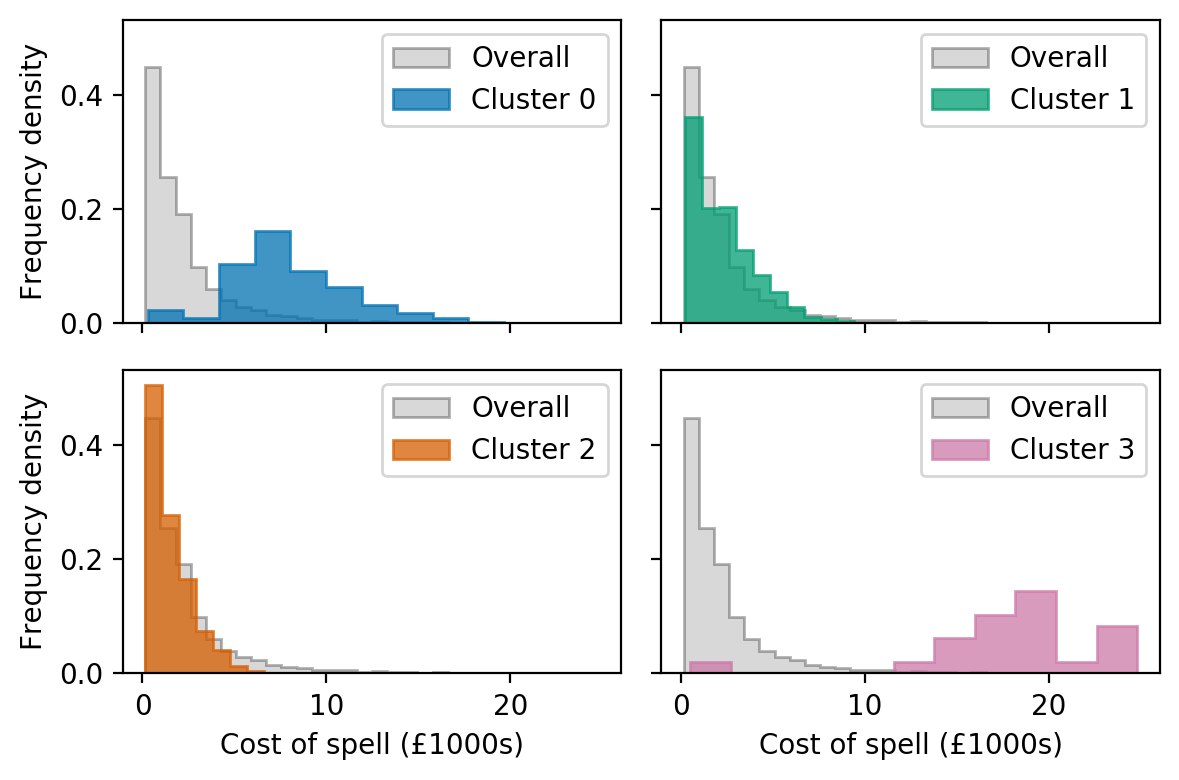

In [9]:
for col in ["charlson_gross", "true_los", "spell_cost"]:
    histograms(copd, col, group="intervention")
    histograms(copd, col, group="cluster")

### LTC proportions

In [10]:
dfs = []
for cluster, values in (
    copd.groupby(["cluster", "spell_id"])[conditions]
    .max()
    .astype(bool)
    .sum(axis=1)
    .reset_index()
    .groupby("cluster")[0]
):
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(
        pd.DataFrame(
            data=proportions.values, index=proportions.index, columns=[cluster]
        )
    )

for intervention, values in (
    copd.groupby(["intervention", "spell_id"])[conditions]
    .max()
    .astype(bool)
    .sum(axis=1)
    .reset_index()
    .groupby("intervention")[0]
):
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(
        pd.DataFrame(
            data=proportions.values,
            index=proportions.index,
            columns=[intervention],
        )
    )

ltcs_proportions = pd.concat(dfs, axis=1).fillna(0)

values = copd.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1)
proportions = values.value_counts(normalize=True)

ltcs_proportions["Population"] = proportions
ltcs_proportions

,0,1,2,3,both,none,pr,sn,Population
1,0.361860,0.000000,0.669542,0.173077,0.717557,0.458912,0.618344,0.533186,0.426577
2,0.385116,0.327759,0.288388,0.294872,0.221374,0.315721,0.275165,0.331858,0.298662
3,0.196279,0.432871,0.040610,0.275641,0.038168,0.157471,0.078508,0.101770,0.167495
4,0.047442,0.182035,0.001460,0.192308,0.015267,0.051668,0.024096,0.024336,0.076864
5,0.008372,0.045867,0.000000,0.051282,0.007634,0.012982,0.003887,0.004425,0.021415
6,0.000930,0.010511,0.000000,0.012821,0.000000,0.002986,0.000000,0.004425,0.007457
7,0.000000,0.000956,0.000000,0.000000,0.000000,0.000260,0.000000,0.000000,0.001338


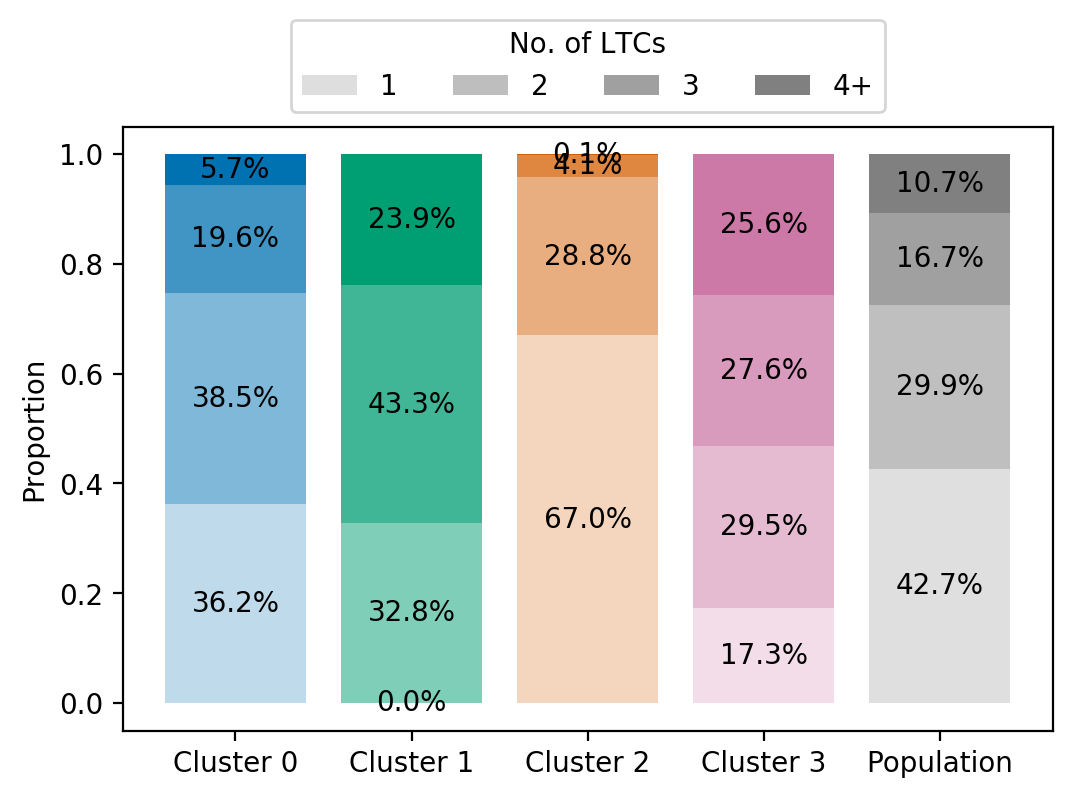

In [11]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in [0, 1, 2, 3, "Population"]:

    bottom = 0
    pos = column
    if isinstance(column, str):
        colour = "gray"
    else:
        colour = colours[column]
        pos = f"Cluster {column}"

    for i in range(1, 5):

        alpha = i / 4
        value = ltcs_proportions.loc[i, column]
        if i == 4:
            value = ltcs_proportions.loc[i:, column].sum()
            i = "4+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(
            pos,
            bottom + 0.5 * value,
            f"{value * 100:.1f}%",
            color="k",
            va="center",
            ha="center",
        )
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = ax.legend(
    handles,
    labels,
    ncol=4,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    title="No. of LTCs",
)

plt.savefig(
    "../img/cluster_ltcs.pdf",
    bbox_extra_artists=[leg],
    bbox_inches="tight",
    transparent=True,
)

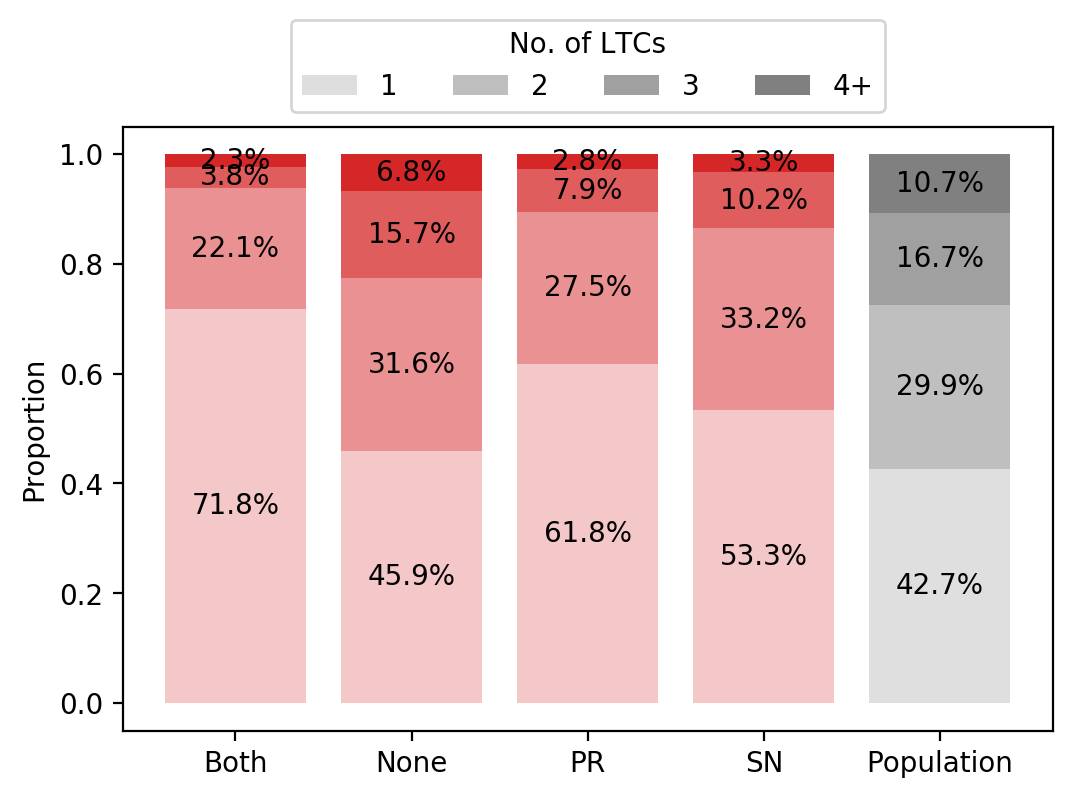

In [12]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in ["both", "none", "pr", "sn", "Population"]:

    bottom = 0
    pos = column
    if column == "Population":
        colour = "gray"
    else:
        colour = "tab:red"
        pos = intervention_labels[column]
        if column in ["pr", "sn"]:
            pos = column.upper()

    for i in range(1, 5):

        alpha = i / 4
        value = ltcs_proportions.loc[i, column]
        if i == 4:
            value = ltcs_proportions.loc[i:, column].sum()
            i = "4+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(
            pos,
            bottom + 0.5 * value,
            f"{value * 100:.1f}%",
            color="k",
            va="center",
            ha="center",
        )
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = ax.legend(
    handles,
    labels,
    ncol=4,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    title="No. of LTCs",
)

plt.savefig(
    "../img/intervention_ltcs.pdf",
    bbox_extra_artists=[leg],
    bbox_inches="tight",
    transparent=True,
)

### ICD proportions

In [13]:
dfs = []
for cluster, values in copd.groupby("cluster")["n_icds"]:
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(
        pd.DataFrame(
            data=proportions.values, index=proportions.index, columns=[cluster]
        )
    )

for intervention, values in copd.groupby("intervention")["n_icds"]:
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(
        pd.DataFrame(
            data=proportions.values,
            index=proportions.index,
            columns=[intervention],
        )
    )

nicds_proportions = pd.concat(dfs, axis=1).fillna(0)

values = copd["n_icds"]
proportions = values.value_counts(normalize=True)

nicds_proportions["Population"] = proportions
nicds_proportions

,0,1,2,3,both,none,pr,sn,Population
1,0.004651,0.000000,0.039151,0.000000,0.038168,0.026873,0.030703,0.019912,0.027627
2,0.013023,0.005733,0.086795,0.000000,0.114504,0.055433,0.081617,0.061947,0.062621
3,0.030698,0.030100,0.134970,0.019231,0.152672,0.095937,0.123591,0.086283,0.102772
4,0.062326,0.061156,0.160053,0.006410,0.175573,0.124497,0.146522,0.095133,0.129109
5,0.091163,0.082656,0.152356,0.038462,0.175573,0.128262,0.137583,0.132743,0.131228
6,0.088372,0.119446,0.132316,0.051282,0.137405,0.125276,0.124368,0.103982,0.124321
7,0.089302,0.113712,0.096350,0.057692,0.038168,0.099701,0.094831,0.115044,0.098444
8,0.086512,0.131868,0.070604,0.070513,0.053435,0.086200,0.079674,0.079646,0.083986
9,0.099535,0.100812,0.043663,0.102564,0.045802,0.063222,0.054800,0.064159,0.061055
10,0.093023,0.089823,0.030392,0.089744,0.030534,0.053096,0.033424,0.070796,0.048900


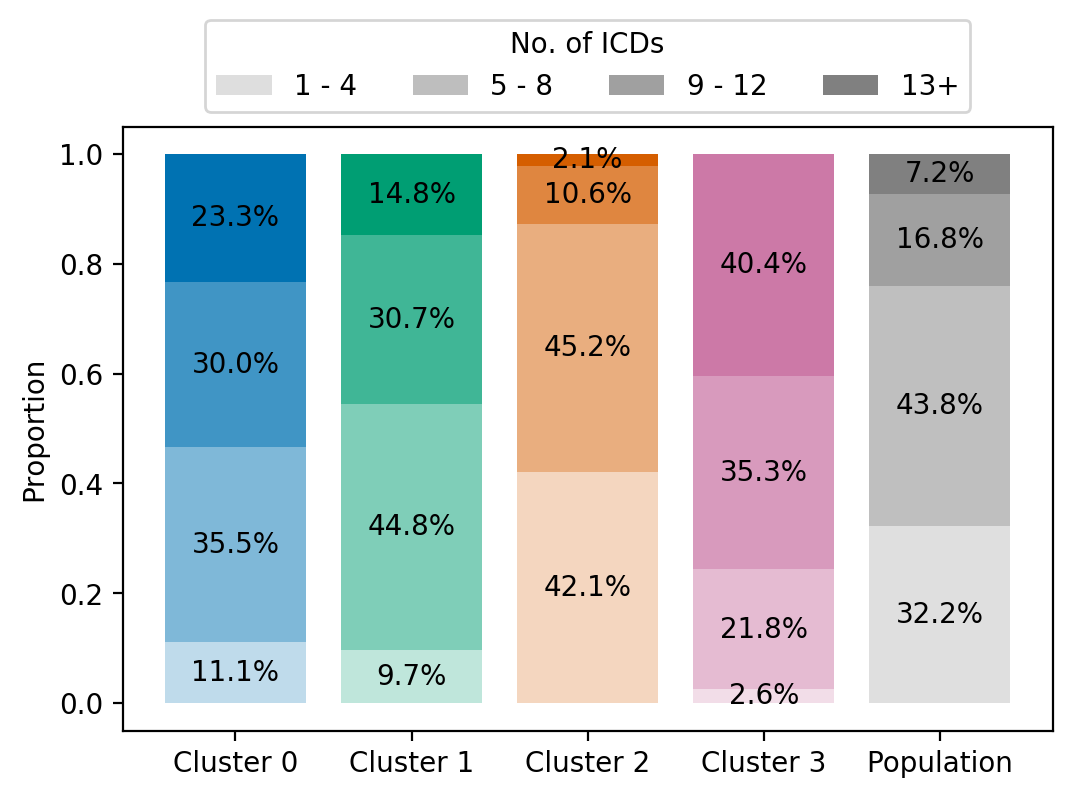

In [14]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in [0, 1, 2, 3, "Population"]:

    bottom = 0
    pos = column
    if isinstance(column, str):
        colour = "gray"
    else:
        colour = colours[column]
        pos = f"Cluster {column}"

    for i in range(4):

        alpha = (i + 1) / 4
        if i == 0:
            value = nicds_proportions.loc[:4, column].sum()
            i = "1 - 4"
        if i == 1:
            value = nicds_proportions.loc[5:8, column].sum()
            i = "5 - 8"
        if i == 2:
            value = nicds_proportions.loc[9:12, column].sum()
            i = "9 - 12"
        if i == 3:
            value = nicds_proportions.loc[13:, column].sum()
            i = "13+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(
            pos,
            bottom + 0.5 * value,
            f"{value * 100:.1f}%",
            color="k",
            va="center",
            ha="center",
        )
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = ax.legend(
    handles,
    labels,
    ncol=4,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    title="No. of ICDs",
)

plt.savefig(
    "../img/cluster_icds.pdf",
    bbox_extra_artists=[leg],
    bbox_inches="tight",
    transparent=True,
)

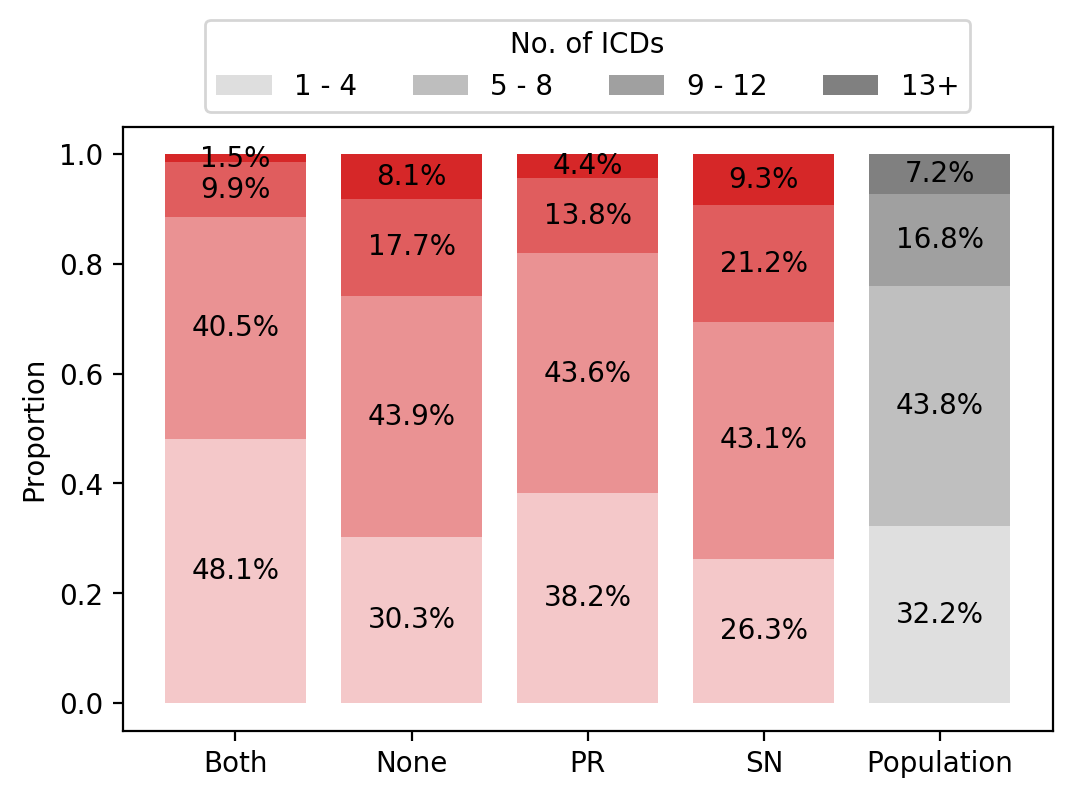

In [15]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in ["both", "none", "pr", "sn", "Population"]:

    bottom = 0
    pos = column
    if column == "Population":
        colour = "gray"
    else:
        colour = "tab:red"
        pos = intervention_labels[column]
        if column in ["pr", "sn"]:
            pos = column.upper()

    for i in range(4):

        alpha = (i + 1) / 4
        if i == 0:
            value = nicds_proportions.loc[:4, column].sum()
            i = "1 - 4"
        if i == 1:
            value = nicds_proportions.loc[5:8, column].sum()
            i = "5 - 8"
        if i == 2:
            value = nicds_proportions.loc[9:12, column].sum()
            i = "9 - 12"
        if i == 3:
            value = nicds_proportions.loc[13:, column].sum()
            i = "13+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(
            pos,
            bottom + 0.5 * value,
            f"{value * 100:.1f}%",
            color="k",
            va="center",
            ha="center",
        )
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = ax.legend(
    handles,
    labels,
    ncol=4,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    title="No. of ICDs",
)

plt.savefig(
    "../img/intervention_icds.pdf",
    bbox_extra_artists=[leg],
    bbox_inches="tight",
    transparent=True,
)

# Cluster summary

In [16]:
total_spells = len(copd)
total_cost = copd["spell_cost"].sum()
rounding = 2

characteristic_to_func = {
    "Percentage of spells": lambda data: (len(data) / total_spells) * 100,
    "Mean spell cost, £": lambda data: data["spell_cost"].mean(),
    "Percentage of recorded costs": lambda data: (
        data["spell_cost"].sum() / total_cost
    )
    * 100,
    "Median age": lambda data: data["age"].median(),
    "Minimum LOS": lambda data: data["true_los"].min(),
    "Mean LOS": lambda data: data["true_los"].mean(),
    "Maximum LOS": lambda data: data["true_los"].max(),
    "Median COPD adm. in last year": lambda data: data[
        "n_copd_admissions_last_year"
    ].median(),
    "Median no. of LTCs": lambda data: data.groupby("spell_id")[conditions]
    .max()
    .astype(bool)
    .sum(axis=1)
    .median(),
    "Median no. of ICDs": lambda data: data["n_icds"].median(),
    "Median CCI": lambda data: data["charlson_gross"].median(),
}

In [17]:
overall_characteristics = pd.DataFrame(index=[0, 1, 2, 3, "Population"])
for col, func in characteristic_to_func.items():

    overall_characteristics.loc["Population", col] = func(copd)
    for cluster, data in copd.groupby("cluster"):
        overall_characteristics.loc[cluster, col] = func(data)

In [18]:
overall_characteristics

,Percentage of spells,"Mean spell cost, £",Percentage of recorded costs,Median age,Minimum LOS,Mean LOS,Maximum LOS,Median COPD adm. in last year,Median no. of LTCs,Median no. of ICDs,Median CCI
0,9.899622,8051.231618,29.013679,77.0,12.822917,25.307186,51.360417,2.0,2.0,9.0,9.0
1,19.274335,2309.634930,19.380590,77.0,0.011111,6.473413,30.859028,1.0,3.0,8.0,20.0
2,69.389447,1508.408009,48.204787,71.0,0.000694,4.106826,16.940972,1.0,1.0,5.0,4.0
3,1.436596,17888.432273,3.400943,82.0,48.817361,75.360056,224.927778,2.0,3.0,11.0,18.0
Population,100.000000,2265.398870,100.000000,73.0,0.000694,7.685347,224.927778,1.0,1.0,6.0,4.0


In [19]:
cluster_intervention_proportions = pd.DataFrame(
    columns=[0, 1, 2, 3, "Population"]
)

cluster_intervention_proportions["Population"] = (
    copd["intervention"].value_counts(normalize=True) * 100
)
for cluster, values in copd.groupby("cluster")["intervention"]:
    proportions = (
        values.value_counts(normalize=True)
        .reindex(["none", "pr", "sn", "both"])
        .fillna(0)
    )
    cluster_intervention_proportions[cluster] = proportions * 100

new_index = [
    intervention_labels.get(i) + ", %"
    for i in cluster_intervention_proportions.index
]
cluster_intervention_proportions.index = new_index

cluster_intervention_proportions

,0,1,2,3,Population
"None, %",80.186047,83.420927,65.759788,89.743590,70.936550
"PR, %",15.813953,13.425705,27.976111,8.974359,23.694631
"SN, %",3.813953,2.866699,4.631719,1.282051,4.162446
"Both, %",0.186047,0.286670,1.632382,0.000000,1.206373


In [20]:
cluster_conditions = {}
for cluster, data in copd.groupby("cluster"):
    cluster_conditions[cluster] = (
        data.groupby("spell_id")[conditions].max().astype(bool)
    )

overall_condition = pd.DataFrame(columns=[0, 1, 2, 3, "Population"])
for label, data in cluster_conditions.items():
    overall_condition[label] = data.mean() * 100

overall_condition["Population"] = (
    pd.concat(cluster_conditions.values()).mean() * 100
)
overall_condition = overall_condition.sort_values("Population", ascending=False)

condition_labels = {
    "ami": "AMI",
    "cva": "CVA",
    "chf": "CHF",
    "ctd": "CTD",
    "dementia": "Dementia",
    "diabetes": "Diabetes",
    "liver_disease": "Liver disease",
    "peptic_ulcer": "Peptic ulcer",
    "pvd": "PVD",
    "pulmonary_disease": "Pulmonary disease",
    "cancer": "Cancer",
    "diabetic_complications": "Diabetic compl.",
    "paraplegia": "Paraplegia",
    "renal_disease": "Renal disease",
    "metastatic_cancer": "Metastatic cancer",
    "sever_liver_disease": "Severe liver disease",
    "hiv": "HIV",
    "cdiff": "C. diff",
    "mrsa": "MRSA",
    "obese": "Obesity",
    "sepsis": "Sepsis",
}

overall_condition.index = [
    condition_labels[i] + ", %" for i in overall_condition.index
]

In [21]:
summary = pd.concat(
    [
        overall_characteristics.T,
        cluster_intervention_proportions,
        overall_condition,
    ],
    sort=False,
).round(2)

index = pd.MultiIndex.from_tuples(
    [
        *(("Characteristics", i) for i in overall_characteristics.T.index),
        *(
            ("Intervention prevalence", i)
            for i in cluster_intervention_proportions.index
        ),
        *(("LTC prevalence", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population", "")]
)

summary.index = index
summary.columns = columns

summary.to_latex("../tex/summary.tex", multicolumn=False, bold_rows=True)

summary

Cluster           \
                                                             0        1   
Characteristics         Percentage of spells              9.90    19.27   
                        Mean spell cost, £             8051.23  2309.63   
                        Percentage of recorded costs     29.01    19.38   
                        Median age                       77.00    77.00   
                        Minimum LOS                      12.82     0.01   
                        Mean LOS                         25.31     6.47   
                        Maximum LOS                      51.36    30.86   
                        Median COPD adm. in last year     2.00     1.00   
                        Median no. of LTCs                2.00     3.00   
                        Median no. of ICDs                9.00     8.00   
                        Median CCI                        9.00    20.00   
Intervention prevalence None, %                          80.19    83.42   
                        PR, %                            15.81    13.43   
                        SN, %                             3.81     2.87   
                        Both, %                           0.19     0.29   
LTC prevalence          Pulmonary disease, %            100.00   100.00   
                        Diabetes, %                      19.07    28.14   
                        AMI, %                           13.86    22.93   
                        CHF, %                           12.47    53.80   
                        Renal disease, %                  7.53    19.54   
                        Cancer, %                         7.53    12.28   
                        Dementia, %                       6.88    21.26   
                        CVA, %                            8.65    13.33   
                        PVD, %                            4.37     7.69   
                        CTD, %                            5.12     4.25   
                        Obesity, %                        2.51     3.01   
                        Metastatic cancer, %              1.49     4.54   
                        Paraplegia, %                     1.30     3.73   
                        Diabetic compl., %                0.19     0.86   
                        Peptic ulcer, %                   1.58     0.81   
                        Sepsis, %                         1.77     0.91   
                        Liver disease, %                  0.28     0.48   
                        C. diff, %                        0.74     0.10   
                        Severe liver disease, %           0.19     0.43   
                        MRSA, %                           0.28     0.05   
                        HIV, %                            0.00     0.00   

                                                                          \
                                                             2         3   
Characteristics         Percentage of spells             69.39      1.44   
                        Mean spell cost, £             1508.41  17888.43   
                        Percentage of recorded costs     48.20      3.40   
                        Median age                       71.00     82.00   
                        Minimum LOS                       0.00     48.82   
                        Mean LOS                          4.11     75.36   
                        Maximum LOS                      16.94    224.93   
                        Median COPD adm. in last year     1.00      2.00   
                        Median no. of LTCs                1.00      3.00   
                        Median no. of ICDs                5.00     11.00   
                        Median CCI                        4.00     18.00   
Intervention prevalence None, %                          65.76     89.74   
                        PR, %                            27.98      8.97   
                        SN, %                             4.63  